In [ ]:
# this is a tool for debugging in python that you can use it for debugging in this assignment. 
# when you finished debugging, please remember to delete the decorater @pysnooper.snoop on top of the functions. 
!pip install pysnooper

#  Gibbs sampling algorithm for Latent Dirichlet Allocation. 

We are going to understand the idea of latent Dirichlet allocation (LDA), a flexible model to estimate the properties of text. On the example of
LDA, the usage of Gibbs sampling is shown as a straight-forward means of approximate
inference in Bayesian networks. 


## Part 1: Reading and Short Essay

### Please read the following paper via [this link](https://www.pnas.org/content/101/suppl_1/5228).

    Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.



The notations in the aforementioned reference varies. Please be careful when you are reading. 



### Please write a short essay to describe the following subjects, 
1. The probabilistic graphcial models and dependencies for LDA model. Please define notations before refering to.  
2. The Gibbs sampling update steps for the parameters of LDA. Deriving the update steps should be straightforward after writing the dependencies of the parameters in the graphical model.
3. The goal of Gibbs Sampling for the inference Latent Dirichlet Allocation? 


**Optional**

If you would like to know more about the mathematical and technical details, please read **Section 5**, [Parameter estimation for text analysis](http://www.arbylon.net/publications/text-est.pdf).

Please note that all the comments and notations in this jupyter notebook follows this reference for your convenience.

1. answer -->
Probabilistic graphical models are a set of algorithms aimed at uncovering the latent subject organisation in massive document archives.
LDA (Latent Dirichlet Allocation) is a probabilistic generative model of a corpus. The core premise is that documents are represented as random mixtures of latent subjects, each of which is defined by a word distribution.
 Let’s suppose there is a machine that produces dice and we can control whether the machine will always produce a dice with equal weight to all sides, or will there be any bias for some sides. So, the machine producing dice is a distribution as it is producing dice of different types. Also, we know that the dice itself is a distribution as we get multiple values when we roll a dice. This is what it means to be a distribution of distributions and this is what Dirichlet is. Here, in the context of topic modeling, the Dirichlet is the distribution of topics in documents and distribution of words in the topic. It might not be very clear at this point of time, but it’s fine as we will look at it in more detail in a while.
Allocation: This means that once we have Dirichlet, we will allocate topics to the documents and words of the document to topics.
That’s it. This is what LDA is in a nutshell. Now let’s understand how this works in topic modeling.
Just to recap, what LDA says is that each word in each document comes from a topic and the topic is selected from a per-document distribution over topics. So we have two matrices:
     ϴtd = P(t|d) which is the probability distribution of topics in documents
     Фwt = P(w|t) which is the probability distribution of words in topics
And, we can say that the probability of a word given document i.e. P(w|d) is equal to:
P(w|t,d) = P(w|t)
2. answer -->
Gibbs sampling is a method for sampling conditional distributions of variables repeatedly until the distribution over states converges to the true distribution over time. This is a more abstract idea that necessitates a thorough understanding of Monte Carlo Markov Chains and the Bayes theorem. These ideas, as well as the arithmetic that underpins them, are fairly sophisticated, and are beyond the scope of this blog. I'll try to convey an understanding of how Gibbs Sampling is used to find subjects in documents.
As I previously stated, we will begin by assuming that we are familiar with and matrices. Now we'll gradually adjust these matrices until we arrive at an answer that optimises the likelihood of the data we have.
We'll do it word by word, changing the topic assignment of one word at a time. We'll assume we don't know the topic assignment for the given word, but we do know the topic assignments for all other words in the text, and we'll try to guess what this word's topic will be.
If we think about it mathematically, we're trying to discover a conditional probability distribution for a single word's subject assignment based on the rest of the topic assignments. We'll receive a conditional probability equation that looks like this for a single word w in document d that belongs to topic k if we ignore all the mathematical calculations:
the dot product of ϴtd * Фwt is in our case 

3 . answer --> 
According to the generative process, the purpose of inference in LDA is to infer the underlying subjects that explain the documents given a corpus.
it works by sampling each of those variables given the other variables (full conditional distribution).
Essentially, we're counting the number of words and documents assigned to specific subjects. For the entire conditionals, those are adequate statistics.

The rest is as simple as plugging the entire conditionals into the Gibbs Sampling framework.


In [ ]:
%matplotlib inline

## Part 2 Implementation of LDA and Inference via Gibbs sampling for LDA 
Although latent Dirichlet allocation is still a relatively simple model, exact inference is generally intractable. The solution to this is to use approximate inference algorithms. Gibbs sampling is a special case of Markov-chain Monte Carlo (MCMC) simulation and often yields relatively simple algorithms for approximate inference in high-dimensional models such as LDA. Therefore we select this approach and present a derivation that is more detailed than the original one by Griffiths and Steyvers. 


To derive a Gibbs sampler for LDA, we apply the hidden-variable method from above. The hidden variables in our model are $z_{d, w}$, i.e., the topic that appear with the word $w$ in document $d$ . We do not need to include, i.e., can integrate out, the parameter sets $\Theta$ and $\Phi$ because they can be interpreted as statistics of the associations between the observed word and the corresponding topic, the state variables of the Markov chain. 

We will use Gibbs sampling for LDA. 
distribution. During the inference, the distribution of topics in docuemnts, $\mathbf{\theta}$, the distribution of words in topics $\mathbf{\phi}$, and likelihood 
$p(\mathbf{w}|\mathbf{z})$ are estimated. 


### Settings
1. we have $T$ topics
2. The copus are consist of $D$ documents, and there are $W$ words within each document $d$. 
3. For dirichlet distribution of $\mathbf{\phi}$, the the number of prior parameters are equal to the number of vocabulary. The prior parameters are all of the same value, $\beta$. 
4. For dirichlet distribution of $\mathbf{\theta}$, the the number of prior parameters are equal to the number of topics. The prior parameters are all of the same value, $\alpha$. 

###  Argument Definitions and Types 



```
z: z must take in (d,w,i) as input, corresponding to 
    topic indicator for i-th obserevation of word w in doc d.
    z is a python dictionary. 
```
```
topic_word_matrix: of dimension (T, W).  
    It refers to the topic of each word. t-th row of topic_word_matrix corresponds to the word observation counts for topic $t$. 

```     
In the first reference, ```topic_word_matrix[j, w]``` is noted as $n_j^{(w)}$, which is the number of times word $w$ has been assigned
to topic $j$. 


```
doc_topic_matrix: of dimension (D, T). It refers to the topic counts for each document. 

```
```doc_topic_matrix[d, j]``` is noted as $n_j^{(d)}$ the number of times a word from document $d$ has been assigned to topic $j$.  


```
topic_counts: the total number of words has been assigned to each topic. 
```



```
doc_counts: document topic sum 
```


log_likelihood corresponding to the $log(p(\mathbf{w}|\mathbf{z}))$. $p(\mathbf{w}|\mathbf{z})$ is equation [2] in the first reference. 




In [ ]:
# -*- coding: utf-8 -*-
"""
LDA implementation in Python

@author: Michael Zhang
"""

import matplotlib.pyplot as plt
import numpy as np
import scipy
import pysnooper
import time
from scipy.special import gammaln
class LDA(object):
    
    def __init__(self, tdm, T, alpha = 1., beta=1., iteration=100):
        """
        tdm: the copus, of (D * Num_words_in_corpus), 
            the value of each entry is the counts of corresponding words in this the corresponding document.
            e.g.
            tdm[d, w] = number of word w appears in document d. 
        T: the number of topics 
        
        """
        self.tdm = tdm
       
        self.D, self.W = self.tdm.shape                
        self.alpha= alpha
        
        self.beta = beta
        
        self.T = T 
        self.iteration = iteration
        
        # z must take in (d,w,i) as input, corresponding to 
        # topic indicator for i-th obserevation of word w in doc d
        self.z = {} 
        self.topic_word_matrix = np.zeros((self.T, self.W)) 
        self.doc_topic_matrix = np.zeros((self.D, self.T))
        self.topic_counts = np.zeros(self.T)
        self.doc_counts = np.zeros(self.D)
        self.log_likelihood = np.zeros(self.iteration)
        self._init_matrix()
        
    #@pysnooper.snoop('init.log')    
    def _init_matrix(self):
        """
        for all words
        1. sample a topic randomly from T topics for each word 
        2. increment topic word count, self.topic_word_matrix
        3. increment document topic count,  self.doc_topic_matrix 
        4. update the topic indicator z. 
        """
        for d in range(self.D):
            doc = scipy.sparse.coo_matrix(self.tdm[d])
            
            word_freq_topic = zip(doc.col, doc.data)
            for w, frequency in word_freq_topic:
                for i in range(frequency):
                    ############ Finish the following initialization steps #############
                    # 1. sample a topic randomly from T topics for each word 

                    topic = np.random.randint(self.T)
                    # 2. increment topic word count, self.topic_word_matrix
                    ## +++++++++ insert code here ++++++++++++++++++++++++###
                    self.topic_word_matrix += 1 
                    # 3. increment document topic count,  self.doc_topic_matrix 
                    ## +++++++++ insert code here ++++++++++++++++++++++++###
                    self.doc_topic_matrix += 1
                    # 4. update the topic indicator z. 
                    ## +++++++++ insert code here ++++++++++++++++++++++++###
                    ###################################################################  
                    self.z[(d,w,i)] = topic
        self.topic_counts = self.topic_word_matrix.sum(axis=1)
        self.doc_counts = self.doc_topic_matrix.sum(axis=1)
   
    # @pysnooper.snoop('fit.log')    
    def fit(self):
        for it in range(self.iteration):
            # iterate over all the documents
            for d in range(self.D):
            # iterate over all the words in d
                for w in self.tdm[d].indices: 
                    # iterate over number of times observed word w in doc d
                    for i in range(self.tdm[d,w]):
                        # we apply the hidden-varible method of Gibbs sampler, the hidden variable is z[(d,w,i)]

                        
                        
                        
                        self.doc_topic_matrix[d,self.z[(d,w,i)]] -= 1
                        #print(self.doc_topic_matrix[d,self.z[(d,w,i)]])
                        
                        self.doc_counts[d] -= 1
                        self.topic_word_matrix[self.z[(d,w,i)],w] -= 1
                        #topic_word_matrix[j, w] njw
                        #doc_topic_matrix[d, j] njd
                        
                        self.topic_counts[self.z[(d,w,i)]] -= 1
                        
                        
                        ######++++++++++++++++++++++++++++++++++++++########
                        # estimation of phi and theta for the current corpus 
                        # according to equation [6] [7]
                        #topic probablity for every word
                        phi_hat = (self.topic_word_matrix[self.z[(d,w,i)],w] + self.beta ) / (self.topic_counts[self.z[(d,w,i)]] + (self.beta * self.W))
                        ## +++++++++ insert code here ++++++++++++++++++++++++###
                        #topic probablity for every document 
                        theta_hat = (self.doc_topic_matrix[d,self.z[(d,w,i)]] + self. alpha ) / (self.doc_counts[d] + (self.alpha * self.T) )
                        ## +++++++++ insert code here ++++++++++++++++++++++++###

                        # calculate the full conditional distribution, i.e. equation [5], 
                        # please observe the relationship between equation [5], [6], and [7]
                        # full conditional probablity is the dot product of phi_hat and theta_hat
                        full_conditional = phi_hat * theta_hat
                        # normalize full_conditional such that it summation equals to 1. 
                        
                        full_conditional /= np.sum(full_conditional)
                        
                        # sample a topic for i-th obserevation of word w in doc d based on full_conditional
                        
                        self.z[(d,w,i)] = np.random.randint(full_conditional)
                        ## +++++++++ insert code here ++++++++++++++++++++++++###
                        
                        #topic = np(self.T)
                        # update z, doc_topic_matrix, doc_counts, topic_word_matrix, topic_counts here. 
                        self.doc_topic_matrix[d,self.z[(d,w,i)]] += 1
                        self.doc_counts[d] += 1
                        self.topic_word_matrix[self.z[(d,w,i)],w] += 1
                        self.topic_counts[self.z[(d,w,i)]] += 1
                        self.z[(d,w,i)] +=1 

            # Equation 2  log P(w|z)  for each iteration based on Equation [2]
            ## +++++++++ insert code below ++++++++++++++++++++++++###
            self.log_likelihood[it] += gammaln(self.W * self.beta)
            self.log_likelihood[it] -= self.W * gammaln(self.beta)
            self.log_likelihood[it] += np.sum(gammaln(self.topic_word_matrix[ 1, it] + self.beta))
            #self.log_likelihood[it] -= gammaln(np.sum(self.W , self.beta))
            ############################################################
            print('Iteration %i\t LL: %.2f' % (it,self.log_likelihood[it]))



### Experiment 1: Well separated synthetic dataset. 

This synthetic dataset consists of 100 documents, and 500 words as total number of vocabulary There are 5 topics in total. 

In this experiment, you are not required to write any additional code. Run the following code, and see if your topic_word_matrix could resemble true "phi", i.e. the true distribution of words in each topic, up to reordering. 



In [ ]:
from os import sync
# dataloading 
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import scipy

synthetic_data = scipy.io.loadmat('/content/well_separated_synthetic.mat')

sk_tdm = scipy.sparse.csr_matrix(synthetic_data['W'])

sk_tdm # of shape 100 \times 500 

<100x500 sparse matrix of type '<class 'numpy.int32'>'
	with 8552 stored elements in Compressed Sparse Row format>

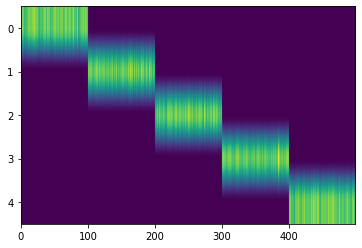

In [ ]:

# first run LDA on synthetic data set, 
# if code works then topic_word_matrix should 
# resemble true "phi", up to reordering

# distribution of words in 5 topics, 
plt.imshow(synthetic_data['phi'],aspect='auto')


In [ ]:
# run LDA with 5 topics on synthetic data set
lda = LDA(sk_tdm, T=5, iteration=100)
lda.fit()


Iteration 0	 LL: 84667.99
Iteration 1	 LL: 84539.06
Iteration 2	 LL: 84078.77
Iteration 3	 LL: 84078.77
Iteration 4	 LL: 83811.91
Iteration 5	 LL: 84051.16
Iteration 6	 LL: 83986.74
Iteration 7	 LL: 83471.56
Iteration 8	 LL: 82837.22
Iteration 9	 LL: 83278.45
Iteration 10	 LL: 83011.84
Iteration 11	 LL: 82111.55
Iteration 12	 LL: 82249.28
Iteration 13	 LL: 81432.38
Iteration 14	 LL: 81551.65
Iteration 15	 LL: 81111.36
Iteration 16	 LL: 82782.08
Iteration 17	 LL: 80927.97
Iteration 18	 LL: 81524.13
Iteration 19	 LL: 81175.55
Iteration 20	 LL: 81551.65
Iteration 21	 LL: 80231.48
Iteration 22	 LL: 82478.90
Iteration 23	 LL: 80460.52
Iteration 24	 LL: 79380.02
Iteration 25	 LL: 81707.65
Iteration 26	 LL: 78255.31
Iteration 27	 LL: 79956.71
Iteration 28	 LL: 79251.92
Iteration 29	 LL: 79050.67
Iteration 30	 LL: 81386.51
Iteration 31	 LL: 79553.90
Iteration 32	 LL: 77597.70
Iteration 33	 LL: 74654.55
Iteration 34	 LL: 80937.14
Iteration 35	 LL: 80836.29
Iteration 36	 LL: 77725.52
Iteration 3

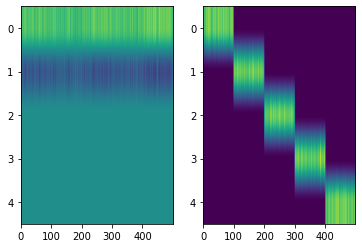

In [ ]:
# compare LDA topic word matrix and true topic word distribution
f,a = plt.subplots(1,2)

a[0].imshow(lda.topic_word_matrix, aspect='auto')
a[1].imshow(synthetic_data['phi'], aspect='auto')

### Experiment 2.

In this experiment, we use a real-world dataset, with 20 topics (newsgroups). 
1. you need to build and fit LDA model. 
2. get top 10 words in each topic, (should make sense) 
3. plot train loglikelihood, i.e. equation [2] in the reference paper, (should increase over iterations)




In [ ]:
# data loading 
# create term document matrix, documents from collection of 20 newsgroups
count_vector = CountVectorizer(stop_words="english", 
                                min_df=.01, 
                                max_df=.95)
data_set = datasets.fetch_20newsgroups()

sk_tdm = count_vector.fit_transform(data_set['data'])


In [ ]:
# get list of words in corpus
corpus_words = np.array(count_vector.get_feature_names())    
print(corpus_words)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['00', '000', '01', ..., 'york', 'young', 'zero'], dtype='<U14')

In [ ]:
# run LDA with 20 topics on 20 news groups dataset
lda = LDA(sk_tdm, T=20, iteration=10)
lda.fit()


Iteration 0	 LL: 12899949.91
Iteration 1	 LL: 12887387.31
Iteration 2	 LL: 12890303.31
Iteration 3	 LL: 12883697.46
Iteration 4	 LL: 12880449.90
Iteration 5	 LL: 12866907.47
Iteration 6	 LL: 12878611.94
Iteration 7	 LL: 12885646.02
Iteration 8	 LL: 12883393.43
Iteration 9	 LL: 12593749.95


In [ ]:
# get top 10 words in each topic, should make sense
# 20 X 10 topics 200 words 
for i in range(0,20):
  for j in range(0,20):

    print(lda.topic_word_matrix[i][j])

1020546.0
1014762.0
1009063.0
1009365.0
1008945.0
1010155.0
1007953.0
1006844.0
1006867.0
1029776.0
1012763.0
1006885.0
1018826.0
1020504.0
1017294.0
1021358.0
1023262.0
1007142.0
1022956.0
1018791.0
991394.0
996667.0
1001842.0
1001558.0
1001949.0
1000849.0
1002849.0
1003851.0
1003843.0
983027.0
998479.0
1003822.0
992958.0
991431.0
994342.0
990667.0
988929.0
1003588.0
989207.0
992994.0
1005203.0
1005241.0
1005259.0
1005263.0
1005261.0
1005259.0
1005269.0
1005277.0
1005273.0
1005153.0
1005249.0
1005269.0
1005207.0
1005203.0
1005218.0
1005207.0
1005186.0
1005266.0
1005180.0
1005205.0
1005210.0
1005234.0
1005262.0
1005258.0
1005262.0
1005251.0
1005265.0
1005271.0
1005278.0
1005155.0
1005251.0
1005274.0
1005214.0
1005205.0
1005215.0
1005210.0
1005200.0
1005266.0
1005196.0
1005226.0
1005212.0
1005233.0
1005261.0
1005261.0
1005260.0
1005252.0
1005265.0
1005274.0
1005271.0
1005132.0
1005247.0
1005271.0
1005212.0
1005208.0
1005222.0
1005210.0
1005190.0
1005272.0
1005203.0
1005203.0
1005207.0
1

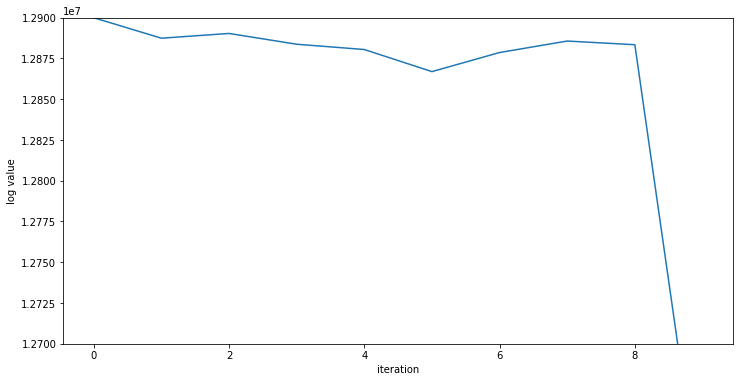

In [ ]:
# plot train loglikelihood, should increase over iterations
fig = plt.figure(figsize=(12, 6))
axes = plt.axes()
axes.set_ylim([12700000, 12900000])
plt.plot(lda.log_likelihood)
plt.plot(lda.iteration)
plt.ylabel('log value')
plt.xlabel('iteration')
plt.show()